#### Downloading & Inspecting Data from Different Satellites

In [3]:
import autoroot

In [4]:
import os
import ast
import eumdac
import datetime
import shutil
import pyproj
import rioxarray
import rasterio
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from typing import Tuple
from pyproj import CRS, Transformer
from satpy import Scene
from goes2go import GOES
from glob import glob
from mpl_toolkits.basemap import Basemap, cm

#### Functions to Convert Coordinate Frames

In [5]:
def add_goes16_crs(ds: xr.Dataset) -> xr.Dataset:
    """
    Adds the Coordinate Reference System (CRS) to the given GOES16 dataset.

    Parameters:
    - ds (xarray.Dataset): The dataset to which the CRS will be added.

    Returns:
    - xarray.Dataset: The dataset with the CRS added.
    """

    # load CRS
    cc = CRS.from_cf(ds.goes_imager_projection.attrs)
    
    # assign CRS to dataarray
    ds.rio.write_crs(cc.to_string(), inplace=True)

    return ds

In [6]:
def add_msg_crs(ds: xr.Dataset, scn_obj) -> xr.Dataset:
    """
    Adds the Coordinate Reference System (CRS) to the given GOES16 dataset.

    Parameters:
    - ds (xarray.Dataset): The dataset to which the CRS will be added.

    Returns:
    - xarray.Dataset: The dataset with the CRS added.
    """
    # TODO: Figure out how to remove the need for the scn_obj parameter
    # load CRS
    crs_wkt = scn_obj.attrs['area'].crs_wkt

    # Define the source CRS from the WKT string
    cc = pyproj.CRS(crs_wkt)
    
    # assign CRS to dataarray
    ds.rio.write_crs(cc.to_string(), inplace=True)

    return ds

In [7]:
def correct_goes16_satheight(ds: xr.Dataset) -> xr.Dataset:

    # get perspective height
    sat_height = ds.goes_imager_projection.attrs["perspective_point_height"]

    # reassign coordinates to correct height
    x_attrs = ds.x.attrs
    ds = ds.assign_coords({"x": ds.x.values * sat_height})
    ds["x"].attrs = x_attrs
    ds["x"].attrs["units"] = "meters"

    y_attrs = ds.y.attrs
    ds = ds.assign_coords({"y": ds.y.values * sat_height})
    ds["y"].attrs = y_attrs
    ds["y"].attrs["units"] = "meters"

    return ds

In [8]:
def convert_lat_lon_to_x_y(crs: str, lon: list[float], lat: list[float]) -> Tuple[float, float]:
    transformer = Transformer.from_crs("epsg:4326", crs, always_xy=True)
    x, y = transformer.transform(lon, lat)
    return x, y

def convert_x_y_to_lat_lon(crs: str, x: list[float], y: list[float]) -> Tuple[float, float]:
    transformer = Transformer.from_crs(crs, "epsg:4326", always_xy=True)
    lon, lat = transformer.transform(x, y)
    return lon, lat


def calc_latlon(ds: xr.Dataset) -> xr.Dataset:
    """
    Calculate the latitude and longitude coordinates for the given dataset

    Args:
        ds: Xarray Dataset to calculate the lat/lon coordinates for, with x and y coordinates

    Returns:
        Xarray Dataset with the latitude and longitude coordinates added
    """
    XX, YY = np.meshgrid(ds.x.data, ds.y.data)
    lons, lats = convert_x_y_to_lat_lon(ds.rio.crs, XX, YY)
    # Check if lons and lons_trans are close in value
    # Set inf to NaN values
    lons[lons == np.inf] = np.nan
    lats[lats == np.inf] = np.nan

    ds = ds.assign_coords({"latitude": (["y", "x"], lats), "longitude": (["y", "x"], lons)})
    ds.latitude.attrs["units"] = "degrees_north"
    ds.longitude.attrs["units"] = "degrees_east"
    return ds

#### Downloading & Loading GOES Data

Downloading using GOES2GO

In [ ]:
# ABI Level 1b Data
G = GOES(satellite=16, product="ABI-L1b-Rad", domain='F')
# download the data nearest a specific time
goes_files = G.nearesttime('2018-10-01 17:00', return_as='filelist', save_dir='.')

Select Channel 13 for Visualization

In [9]:
goes_files = glob('noaa-goes16/ABI-L1b-RadF/2018/274/17/*C15*nc')

In [10]:
ds_goes = xr.open_dataset(goes_files[0])
ds_goes = correct_goes16_satheight(ds_goes)
ds_goes = add_goes16_crs(ds_goes)
ds_goes

<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424, number_of_time_bounds: 2, number_of_image_bounds: 2, band: 1, num_star_looks: 24)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float32 5.434e+06 ... -5.434e+06
  * x                                       (x) float32 -5.434e+06 ... 5.434e+06
    goes_imager_projection                  int64 0
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_id                                 (band) int8 ...
    band_wavelength                         (band) float32 ...
    t_star_look                             (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look               (num_star_looks) float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds, band, num_star_looks
Data variables: (12/30)
    Rad                                     (y, x) float32 ...
    DQF                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    y_image_bounds                          (number_of_image_bounds) float32 ...
    x_image_bounds                          (number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat          float32 ...
    ...                                      ...
    percent_uncorrectable_L0_errors         float32 ...
    earth_sun_distance_anomaly_in_AU        float32 ...
    algorithm_dynamic_input_data_container  int32 ...
    processing_parm_version_container       int32 ...
    algorithm_product_version_container     int32 ...
    star_id                                 (num_star_looks) float32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    production_data_source:    Realtime
    timeline_id:               ABI Mode 3
    date_created:              2018-10-01T17:11:16.7Z
    time_coverage_start:       2018-10-01T17:00:33.7Z
    time_coverage_end:         2018-10-01T17:11:11.0Z
    id:                        1c1cd56a-7877-4971-a110-f640a832f019

#### Downloading MSG Data

Downloading using EUMDAC

In [ ]:
# Insert your personal key and secret into the single quotes
consumer_key = "OqP8jMXE_Xv9VsnG7tahrSD8f2Ya"
consumer_secret = "Z5Gt3gpvdlUiNrtHt0VRxR103P4a"

credentials = (consumer_key, consumer_secret)
token = eumdac.AccessToken(credentials)

print(f"This token '{token}' expires {token.expiration}")

This token 'd8bb293e-6865-3983-8b88-9fb315d7aba5' expires 2024-03-10 18:08:15.972991


In [ ]:
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection('EO:EUM:DAT:MSG:HRSEVIRI')

In [ ]:
start = datetime.datetime.strptime("2018-10-01 17:05:00", "%Y-%m-%d %H:%M:%S")

# Retrieve datasets that match our filter
products = selected_collection.search(
    dtstart=start,
    dtend=start,
    sort="start,time,1")
    
print(f'Found Datasets: {len(products)} datasets for the given time range')

for product in products:
    print(product)

Found Datasets: 1 datasets for the given time range
MSG4-SEVI-MSG15-0100-NA-20181001171244.576000000Z-NA


In [11]:
for selected_product in products:
    for entry in selected_product.entries:
        if entry.endswith('nat'):
            print(f"Selected entry: {entry}")
            with selected_product.open(entry=entry) as fsrc, \
                open(fsrc.name, mode='wb') as fdst:
                    shutil.copyfileobj(fsrc, fdst)
            print(f'Download of file {fsrc.name} finished.')

Selected entry: MSG4-SEVI-MSG15-0100-NA-20181001171244.576000000Z-NA.nat
Download of file MSG4-SEVI-MSG15-0100-NA-20181001171244.576000000Z-NA.nat finished.


Load Data using Satpy

In [25]:
scn = Scene(reader="seviri_l1b_native", filenames=['MSG4-SEVI-MSG15-0100-NA-20181001171244.576000000Z-NA.nat'])

# MSG data contains 12 channels, including the high-resolution visible (HRV) channel.
datasets = scn.available_dataset_names()
scn.load(datasets[1:], generate=False, calibration='radiance')
# Note: The HRV channel comes in 1 km resolution, while the other channels are 3 km resolution.
# Because of the size mismatch, the HRV channel would either need to be downscaled,
# or it needs to the loaded separetely to the other channels

In [26]:
ds_msg = scn.to_xarray()

/opt/anaconda3/lib/python3.9/site-packages/satpy/writers/cf_writer.py:926: UserWarning: Cannot pretty-format "acq_time" coordinates because they are not identical among the given datasets
  dict_dataarrays = make_alt_coords_unique(dict_dataarrays, pretty=pretty)


In [27]:
ds_msg = add_msg_crs(ds_msg, scn['IR_120'])

Select Infrared Channel for Visualization

#### Plotting Datasets

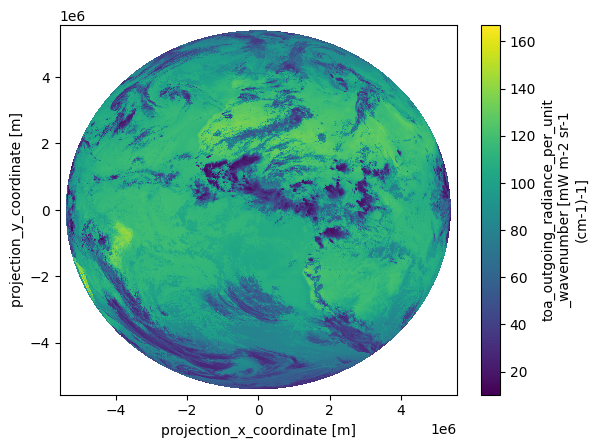

In [54]:
ds_msg['IR_120'].plot()

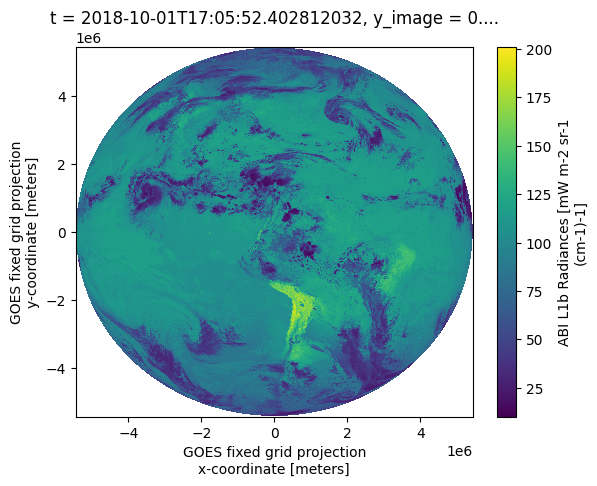

In [72]:
ds_goes.Rad.plot()

#### Converting Coordinates to lat/lon

In [12]:
ds_goes_latlon = calc_latlon(ds_goes)
ds_goes_latlon

<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424, number_of_time_bounds: 2, number_of_image_bounds: 2, band: 1, num_star_looks: 24)
Coordinates:
    t                                       datetime64[ns] 2018-10-01T17:05:5...
  * y                                       (y) float32 5.434e+06 ... -5.434e+06
  * x                                       (x) float32 -5.434e+06 ... 5.434e+06
    goes_imager_projection                  int64 0
    y_image                                 float32 0.0
    x_image                                 float32 0.0
    band_id                                 (band) int8 15
    band_wavelength                         (band) float32 12.3
    t_star_look                             (num_star_looks) datetime64[ns] 2...
    band_wavelength_star_look               (num_star_looks) float32 -999.0 ....
    latitude                                (y, x) float64 nan nan ... nan nan
    longitude                               (y, x) float64 nan nan ... nan nan
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds, band, num_star_looks
Data variables: (12/30)
    Rad                                     (y, x) float32 ...
    DQF                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    y_image_bounds                          (number_of_image_bounds) float32 ...
    x_image_bounds                          (number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat          float64 0.0
    ...                                      ...
    percent_uncorrectable_L0_errors         float64 0.0
    earth_sun_distance_anomaly_in_AU        float64 1.001
    algorithm_dynamic_input_data_container  int32 -2147483647
    processing_parm_version_container       int32 -2147483647
    algorithm_product_version_container     int32 -2147483647
    star_id                                 (num_star_looks) float32 nan ... nan
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    production_data_source:    Realtime
    timeline_id:               ABI Mode 3
    date_created:              2018-10-01T17:11:16.7Z
    time_coverage_start:       2018-10-01T17:00:33.7Z
    time_coverage_end:         2018-10-01T17:11:11.0Z
    id:                        1c1cd56a-7877-4971-a110-f640a832f019

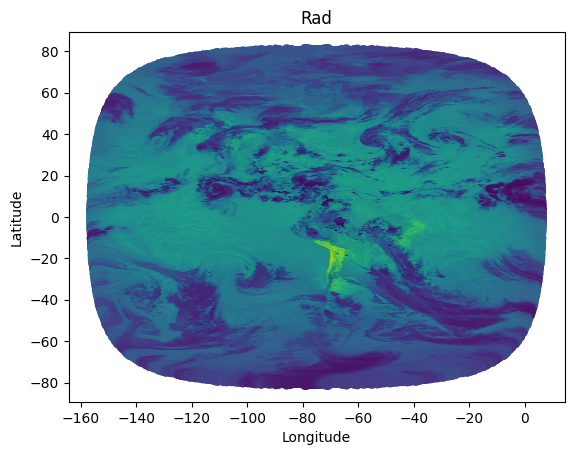

In [171]:
# Create a scatter plot
plt.scatter(ds_goes_latlon['longitude'], ds_goes_latlon['latitude'], c=ds_goes_latlon['Rad'])

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Rad')

# Show the plot
plt.show()

In [28]:
ds_msg_latlon = calc_latlon(ds_msg)
ds_msg_latlon

<xarray.Dataset>
Dimensions:             (y: 3712, x: 3712)
Coordinates: (12/16)
    msg_seviri_fes_3km  int64 0
    IR_016_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
  * y                   (y) float64 -5.566e+06 -5.563e+06 ... 5.569e+06
  * x                   (x) float64 5.566e+06 5.563e+06 ... -5.569e+06
    longitude           (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    latitude            (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    ...                  ...
    IR_120_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    IR_134_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    VIS006_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    VIS008_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    WV_062_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    WV_073_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
Data variables:
    IR_016              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_039              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_087              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_097              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_108              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_120              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_134              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    VIS006              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    VIS008              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    WV_062              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    WV_073              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
Attributes:
    history:      Created by pytroll/satpy on 2024-03-10 19:38:52.820880
    Conventions:  CF-1.7

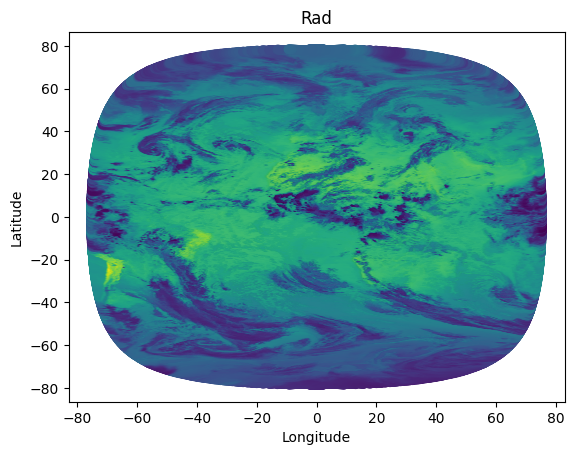

In [211]:
# Create a scatter plot
plt.scatter(ds_msg_latlon['longitude'], ds_msg_latlon['latitude'], c=ds_msg_latlon['IR_120'])

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Rad')

# Show the plot
plt.show()

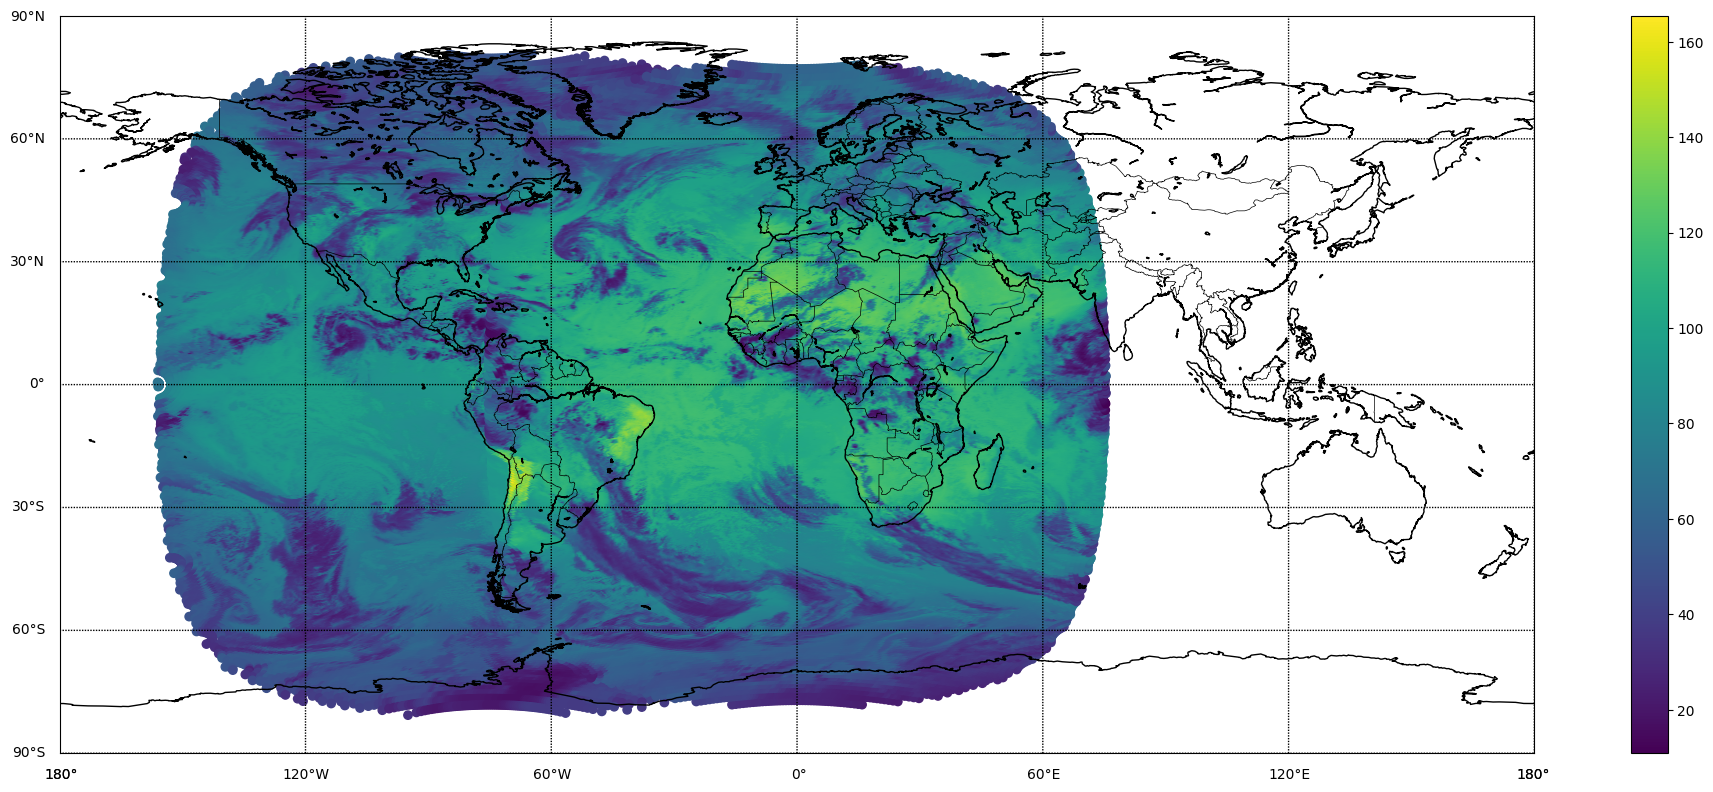

In [70]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))

# Create a Basemap instance
m = Basemap(projection='cyl', resolution='l', lon_0=0, lat_0=0)

# # Draw coastlines and country borders
m.drawcoastlines()
m.drawcountries()

# # Convert latitude and longitude to map coordinates
lon_map, lat_map = m(ds_goes_latlon['longitude'].values[::5, ::5], ds_goes_latlon['latitude'].values[::5, ::5])

# # Create a scatter plot
m.scatter(lon_map, lat_map, c=ds_goes_latlon['Rad'][::5, ::5], latlon=True)

# # Convert latitude and longitude to map coordinates
lon_map, lat_map = m(ds_msg_latlon['longitude'].values[::5, ::5], ds_msg_latlon['latitude'].values[::5, ::5])

# # Create a scatter plot
m.scatter(lon_map, lat_map, c=ds_msg_latlon['IR_120'][::5, ::5], latlon=True)

# Draw meridians (lines of longitude) and label them
meridians = np.arange(-180., 181., 60.)
m.drawmeridians(meridians, labels=[False, False, False, True])

# Draw parallels (lines of latitude) and label them
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[True, False, False, False])

# # Show the plot
plt.colorbar()

plt.tight_layout()
plt.show()